# Environmental Stressors (ES) Score for NYC
## Seasonal Analysis: Summer vs Winter 2023

This notebook calculates Environmental Stressors (ES) scores for both Summer and Winter seasons.

### ES Formula (Anderson et al., 2025; Nayak et al., 2018)
```
ES = 0.25×Temperature + 0.25×Air_Quality + 0.25×Vegetation_Lack + 0.25×Light_Pollution
```

### Data Sources (4 factors × 2 seasons = 8 layers)
| Factor | Description | Source | Resolution |
|--------|-------------|--------|------------|
| Temperature | Surface temperature | Landsat 9 LST | 100m |
| Air Quality | NO2 concentration | Sentinel-5P | ~7km |
| Vegetation Lack | 1 - NDVI | Sentinel-2 | 10m |
| Light Pollution | Nighttime lights intensity | VIIRS DNB | 500m |

### Time Periods
- **Summer (JJA)**: 2023-06-01 to 2023-08-31
- **Winter (DJF)**: 2022-12-01 to 2023-02-28

In [1]:
# First run this cell ONCE to authenticate (opens browser)
import ee
ee.Authenticate()

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


/Users/andrewpark/Desktop/PhD.nosync/Coursework/25FA/Monitoring Cities/00 Final/venv/lib/python3.9/site-packages/google/api_core/_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.6) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)
/Users/andrewpark/Desktop/PhD.nosync/Coursework/25FA/Monitoring Cities/00 Final/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


True

In [2]:
import ee
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# Initialize Earth Engine
ee.Initialize(project='monitoringcities-abp7718')

print("Libraries imported and Earth Engine initialized")

Libraries imported and Earth Engine initialized


## 1. Load NYC Census Tract Boundaries

In [3]:
# Load LCS data (already has NYC census tract geometries)
lcs_file = Path('../Pitch2/LCS_NYC_2023.geojson')
gdf_nyc = gpd.read_file(lcs_file)

print(f"Loaded {len(gdf_nyc)} NYC census tracts")
print(f"CRS: {gdf_nyc.crs}")

Loaded 2327 NYC census tracts
CRS: EPSG:4269


In [4]:
# Create NYC bounding box for GEE filtering
bounds = gdf_nyc.total_bounds  # [minx, miny, maxx, maxy]
nyc_bbox = ee.Geometry.Rectangle([bounds[0], bounds[1], bounds[2], bounds[3]])

print(f"NYC Bounding Box: {bounds}")

NYC Bounding Box: [-74.258843  40.476578 -73.700169  40.917705]


In [5]:
# Convert GeoDataFrame to Earth Engine FeatureCollection
def gdf_to_ee_fc(gdf):
    """Convert GeoDataFrame to Earth Engine FeatureCollection"""
    features = []
    for idx, row in gdf.iterrows():
        geom = row.geometry.__geo_interface__
        props = {col: row[col] for col in gdf.columns if col != 'geometry'}
        props = {k: (float(v) if isinstance(v, (np.floating, np.integer)) else v) 
                 for k, v in props.items()}
        feature = ee.Feature(ee.Geometry(geom), props)
        features.append(feature)
    return ee.FeatureCollection(features)

nyc_tracts_ee = gdf_to_ee_fc(gdf_nyc)
print(f"Created EE FeatureCollection with {nyc_tracts_ee.size().getInfo()} features")

Created EE FeatureCollection with 2327 features


## 2. Define Time Periods

In [6]:
# Time periods for seasonal analysis
# Summer 2023 (JJA)
SUMMER_START = '2023-06-01'
SUMMER_END = '2023-08-31'

# Winter 2022-2023 (DJF)
WINTER_START = '2022-12-01'
WINTER_END = '2023-02-28'

print(f"Summer period (JJA): {SUMMER_START} to {SUMMER_END}")
print(f"Winter period (DJF): {WINTER_START} to {WINTER_END}")

Summer period (JJA): 2023-06-01 to 2023-08-31
Winter period (DJF): 2022-12-01 to 2023-02-28


## 3. Load Landsat Temperature Data (100m resolution)

In [7]:
# Landsat 9 LST loading function
def mask_landsat_clouds(image):
    """Mask clouds in Landsat 9 imagery using QA_PIXEL band"""
    qa = image.select('QA_PIXEL')
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0).And(qa.bitwiseAnd(1 << 4).eq(0))
    return image.updateMask(cloud_mask)

def load_landsat_lst(start_date, end_date, geometry):
    """Load Landsat 9 LST and convert to Celsius"""
    landsat = (ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
        .filterBounds(geometry)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt('CLOUD_COVER', 30))
        .map(mask_landsat_clouds)
    )
    
    def to_celsius(img):
        # ST_B10 is surface temperature, scale factor 0.00341802, offset 149.0
        lst = img.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15)
        return lst.rename('LST')
    
    return landsat.map(to_celsius).mean(), landsat.size().getInfo()

print("Landsat LST loading function defined")

Landsat LST loading function defined


In [8]:
# Load Summer Landsat LST
temp_summer, n_summer_landsat = load_landsat_lst(SUMMER_START, SUMMER_END, nyc_bbox)
temp_summer = temp_summer.rename('Temp_Summer')

print(f"Summer Landsat 9 images: {n_summer_landsat}")

Summer Landsat 9 images: 4


In [9]:
# Load Winter Landsat LST
temp_winter, n_winter_landsat = load_landsat_lst(WINTER_START, WINTER_END, nyc_bbox)
temp_winter = temp_winter.rename('Temp_Winter')

print(f"Winter Landsat 9 images: {n_winter_landsat}")

Winter Landsat 9 images: 6


In [10]:
# Preview: Summer vs Winter Temperature
import geemap.foliumap as geemap

Map1 = geemap.Map(center=[40.7128, -74.0060], zoom=10)

summer_vis = {'min': -5, 'max': 45, 'palette': ['blue', 'yellow', 'red']}
winter_vis = {'min': -5, 'max': 45, 'palette': ['blue', 'yellow', 'red']}

Map1.addLayer(temp_summer.clip(nyc_bbox), summer_vis, 'Summer Temp (°C)')
Map1.addLayer(temp_winter.clip(nyc_bbox), winter_vis, 'Winter Temp (°C)', shown=False)
Map1.addLayer(nyc_tracts_ee.style(color='black', fillColor='00000000', width=0.5), {}, 'NYC Tracts')

print("Temperature Map (Landsat 9 - 100m resolution)")
Map1

Temperature Map (Landsat 9 - 100m resolution)


In [11]:
## 4. Load Air Quality Data (Sentinel-5P NO2)

## 4. Load Air Quality Data (Sentinel-5P NO2)

In [12]:
def load_no2(start_date, end_date, geometry):
    """Load Sentinel-5P NO2 data"""
    no2 = (ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2')
        .filterBounds(geometry)
        .filterDate(start_date, end_date)
        .select('tropospheric_NO2_column_number_density')
    )
    # Multiply by 1e6 for better scale (μmol/m²)
    return no2.mean().multiply(1e6), no2.size().getInfo()

# Summer NO2
air_quality_summer, n_summer_no2 = load_no2(SUMMER_START, SUMMER_END, nyc_bbox)
air_quality_summer = air_quality_summer.rename('Air_Quality_Summer')
print(f"Summer Sentinel-5P NO2 images: {n_summer_no2}")

# Winter NO2
air_quality_winter, n_winter_no2 = load_no2(WINTER_START, WINTER_END, nyc_bbox)
air_quality_winter = air_quality_winter.rename('Air_Quality_Winter')
print(f"Winter Sentinel-5P NO2 images: {n_winter_no2}")

Summer Sentinel-5P NO2 images: 1231
Winter Sentinel-5P NO2 images: 1262


In [13]:
# Preview: Summer vs Winter NO2
Map3 = geemap.Map(center=[40.7128, -74.0060], zoom=10)

no2_vis = {'min': 0, 'max': 120, 'palette': ['green', 'yellow', 'orange', 'red', 'purple']}

Map3.addLayer(air_quality_summer.clip(nyc_bbox), no2_vis, 'Summer NO2 (μmol/m²)')
Map3.addLayer(air_quality_winter.clip(nyc_bbox), no2_vis, 'Winter NO2 (μmol/m²)', shown=False)
Map3.addLayer(nyc_tracts_ee.style(color='black', fillColor='00000000', width=0.5), {}, 'NYC Tracts')

print("Air Quality Map (Sentinel-5P NO2)")
Map3

Air Quality Map (Sentinel-5P NO2)


## 5. Load Vegetation Data (Sentinel-2 NDVI)

In [14]:
def mask_s2_clouds(image):
    """Mask clouds in Sentinel-2 imagery"""
    qa = image.select('QA60')
    cloud_mask = qa.bitwiseAnd(1 << 10).eq(0).And(qa.bitwiseAnd(1 << 11).eq(0))
    return image.updateMask(cloud_mask)

def load_vegetation_lack(start_date, end_date, geometry):
    """Load Sentinel-2 and calculate vegetation lack (1 - NDVI)"""
    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
        .filterBounds(geometry)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .map(mask_s2_clouds)
    )
    
    # Calculate NDVI and invert
    ndvi = s2.map(lambda img: img.normalizedDifference(['B8', 'B4'])).mean()
    vegetation_lack = ee.Image(1).subtract(ndvi)
    
    return vegetation_lack, s2.size().getInfo()

# Summer vegetation
veg_lack_summer, n_summer_s2 = load_vegetation_lack(SUMMER_START, SUMMER_END, nyc_bbox)
veg_lack_summer = veg_lack_summer.rename('Vegetation_Lack_Summer')
print(f"Summer Sentinel-2 images: {n_summer_s2}")

# Winter vegetation
veg_lack_winter, n_winter_s2 = load_vegetation_lack(WINTER_START, WINTER_END, nyc_bbox)
veg_lack_winter = veg_lack_winter.rename('Vegetation_Lack_Winter')
print(f"Winter Sentinel-2 images: {n_winter_s2}")

Summer Sentinel-2 images: 45
Winter Sentinel-2 images: 35


In [15]:
# Preview: Summer vs Winter Vegetation Lack
Map4 = geemap.Map(center=[40.7128, -74.0060], zoom=10)

veg_vis = {'min': 0.3, 'max': 1.0, 'palette': ['darkgreen', 'lightgreen', 'yellow', 'orange', 'brown']}

Map4.addLayer(veg_lack_summer.clip(nyc_bbox), veg_vis, 'Summer Vegetation Lack (1-NDVI)')
Map4.addLayer(veg_lack_winter.clip(nyc_bbox), veg_vis, 'Winter Vegetation Lack (1-NDVI)', shown=False)
Map4.addLayer(nyc_tracts_ee.style(color='black', fillColor='00000000', width=0.5), {}, 'NYC Tracts')

print("Vegetation Lack Map (Sentinel-2)")
Map4

Vegetation Lack Map (Sentinel-2)


## 6. Load Nighttime Lights Data (VIIRS DNB)

In [16]:
def load_nighttime_lights(start_date, end_date, geometry):
    """
    Load VIIRS DNB (Day/Night Band) nighttime lights data.
    Higher values = more light pollution = more urban stress
    """
    viirs = (ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')
        .filterBounds(geometry)
        .filterDate(start_date, end_date)
        .select('avg_rad')  # Average radiance
    )
    return viirs.mean(), viirs.size().getInfo()

# Summer NTL
ntl_summer, n_summer_ntl = load_nighttime_lights(SUMMER_START, SUMMER_END, nyc_bbox)
ntl_summer = ntl_summer.rename('NTL_Summer')
print(f"Summer VIIRS monthly composites: {n_summer_ntl}")

# Winter NTL
ntl_winter, n_winter_ntl = load_nighttime_lights(WINTER_START, WINTER_END, nyc_bbox)
ntl_winter = ntl_winter.rename('NTL_Winter')
print(f"Winter VIIRS monthly composites: {n_winter_ntl}")

Summer VIIRS monthly composites: 3
Winter VIIRS monthly composites: 3


In [17]:
# Preview: Summer vs Winter Nighttime Lights
Map5 = geemap.Map(center=[40.7128, -74.0060], zoom=10)

ntl_vis = {'min': 0, 'max': 200, 'palette': ['black', 'blue', 'purple', 'orange', 'yellow', 'white']}

Map5.addLayer(ntl_summer.clip(nyc_bbox), ntl_vis, 'Summer NTL (nW/cm²/sr)')
Map5.addLayer(ntl_winter.clip(nyc_bbox), ntl_vis, 'Winter NTL (nW/cm²/sr)', shown=False)
Map5.addLayer(nyc_tracts_ee.style(color='white', fillColor='00000000', width=0.5), {}, 'NYC Tracts')

print("Nighttime Lights Map (VIIRS DNB - 500m resolution)")
print("Higher values = more light pollution")
Map5

Nighttime Lights Map (VIIRS DNB - 500m resolution)
Higher values = more light pollution


## 7. Zonal Statistics by Census Tract

In [18]:
def extract_zonal_stats(image, band_name, fc, scale=1000):
    """
    Extract mean values for each census tract
    """
    def reduce_region(feature):
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=feature.geometry(),
            scale=scale,
            maxPixels=1e9
        )
        return feature.set(band_name, stats.get(image.bandNames().get(0)))
    
    return fc.map(reduce_region)

print("Zonal statistics function defined")

Zonal statistics function defined


In [19]:
# Extract zonal statistics for all 8 ES layers (4 factors × 2 seasons)
print("Extracting zonal statistics for all 8 ES layers...")

# Summer factors (4)
print("  Summer Temperature...")
tracts = extract_zonal_stats(temp_summer, 'Temp_Summer', nyc_tracts_ee, scale=100)

print("  Summer Air Quality...")
tracts = extract_zonal_stats(air_quality_summer, 'Air_Quality_Summer', tracts, scale=1000)

print("  Summer Vegetation Lack...")
tracts = extract_zonal_stats(veg_lack_summer, 'Vegetation_Lack_Summer', tracts, scale=100)

print("  Summer Nighttime Lights...")
tracts = extract_zonal_stats(ntl_summer, 'NTL_Summer', tracts, scale=500)

# Winter factors (4)
print("  Winter Temperature...")
tracts = extract_zonal_stats(temp_winter, 'Temp_Winter', tracts, scale=100)

print("  Winter Air Quality...")
tracts = extract_zonal_stats(air_quality_winter, 'Air_Quality_Winter', tracts, scale=1000)

print("  Winter Vegetation Lack...")
tracts = extract_zonal_stats(veg_lack_winter, 'Vegetation_Lack_Winter', tracts, scale=100)

print("  Winter Nighttime Lights...")
tracts_all = extract_zonal_stats(ntl_winter, 'NTL_Winter', tracts, scale=500)

print("Zonal statistics extraction complete! (8 layers)")

Extracting zonal statistics for all 8 ES layers...
  Summer Temperature...
  Summer Air Quality...
  Summer Vegetation Lack...
  Summer Nighttime Lights...
  Winter Temperature...
  Winter Air Quality...
  Winter Vegetation Lack...
  Winter Nighttime Lights...
Zonal statistics extraction complete! (8 layers)


In [ ]:
# Convert results to pandas DataFrame - BATCH BY BOROUGH to avoid timeout
print("Converting results to DataFrame (processing by borough to avoid timeout)...")

boroughs = {
    '005': 'Bronx',
    '047': 'Brooklyn', 
    '061': 'Manhattan',
    '081': 'Queens',
    '085': 'Staten Island'
}

all_data = []

for fips, name in boroughs.items():
    print(f"  Processing {name}...")
    
    borough_tracts = tracts_all.filter(ee.Filter.eq('COUNTYFP', fips))
    
    try:
        results = borough_tracts.getInfo()
        for feature in results['features']:
            props = feature['properties']
            all_data.append(props)
        print(f"    ✓ {name}: {len(results['features'])} tracts")
    except Exception as e:
        print(f"    ✗ {name} error: {e}")

df_es = pd.DataFrame(all_data)
print(f"\nTotal DataFrame shape: {df_es.shape}")

Converting results to DataFrame (processing by borough to avoid timeout)...
  Processing Bronx...


In [ ]:
# Check raw statistics for all 8 factors
es_factors = ['Temp_Summer', 'Air_Quality_Summer', 'Vegetation_Lack_Summer', 'NTL_Summer',
              'Temp_Winter', 'Air_Quality_Winter', 'Vegetation_Lack_Winter', 'NTL_Winter']

print("Raw ES Factor Statistics (8 layers):")
print(df_es[es_factors].describe())

Raw ES Factor Statistics (8 layers):
       Temp_Summer  Air_Quality_Summer  Vegetation_Lack_Summer   NTL_Summer  \
count  2327.000000         2327.000000             2327.000000  2327.000000   
mean     38.782670          103.781740                0.843303    58.332631   
std       2.944171           13.547818                0.100724    35.219197   
min      22.949818           64.151232                0.403185     2.495809   
25%      38.029586           93.476900                0.796668    39.365386   
50%      39.412577          102.920690                0.856161    52.231152   
75%      40.502952          114.992745                0.900673    69.439939   
max      45.477733          128.736635                1.214959   502.795110   

       Temp_Winter  Air_Quality_Winter  Vegetation_Lack_Winter   NTL_Winter  
count  2327.000000         2327.000000             2327.000000  2327.000000  
mean      8.029180          156.930945                0.974738    75.474937  
std       0.98756

## 8. Normalize to Percentiles (0-1)

In [ ]:
def normalize_to_percentile(series):
    """Normalize a series to percentiles (0-1 scale)"""
    return series.rank(pct=True)

# Normalize Summer factors (4)
df_es['Temp_Summer_norm'] = normalize_to_percentile(df_es['Temp_Summer'])  # Higher = more heat stress
df_es['Air_Quality_Summer_norm'] = normalize_to_percentile(df_es['Air_Quality_Summer'])  # Higher NO2 = more stress
df_es['Vegetation_Lack_Summer_norm'] = normalize_to_percentile(df_es['Vegetation_Lack_Summer'])  # Higher = more stress
df_es['NTL_Summer_norm'] = normalize_to_percentile(df_es['NTL_Summer'])  # Higher lights = more stress

# Normalize Winter factors (4)
df_es['Temp_Winter_norm'] = 1 - normalize_to_percentile(df_es['Temp_Winter'])  # INVERT: colder = more stress
df_es['Air_Quality_Winter_norm'] = normalize_to_percentile(df_es['Air_Quality_Winter'])  # Higher NO2 = more stress
df_es['Vegetation_Lack_Winter_norm'] = normalize_to_percentile(df_es['Vegetation_Lack_Winter'])  # Higher = more stress
df_es['NTL_Winter_norm'] = normalize_to_percentile(df_es['NTL_Winter'])  # Higher lights = more stress

print("Normalized ES Factor Statistics (8 layers):")
norm_cols = [f + '_norm' for f in es_factors]
print(df_es[norm_cols].describe())

Normalized ES Factor Statistics (8 layers):
       Temp_Summer_norm  Air_Quality_Summer_norm  Vegetation_Lack_Summer_norm  \
count       2327.000000              2327.000000                  2327.000000   
mean           0.500215                 0.500215                     0.500215   
std            0.288737                 0.288737                     0.288737   
min            0.000430                 0.000430                     0.000430   
25%            0.250322                 0.250322                     0.250322   
50%            0.500215                 0.500215                     0.500215   
75%            0.750107                 0.749893                     0.750107   
max            1.000000                 1.000000                     1.000000   

       NTL_Summer_norm  Temp_Winter_norm  Air_Quality_Winter_norm  \
count      2327.000000       2327.000000              2327.000000   
mean          0.500215          0.499785                 0.500215   
std           0.288

## 9. Calculate ES Scores (Summer & Winter)

In [ ]:
# Calculate ES with equal weighting (0.25 each for 4 factors)
# ES = 0.25×Temperature + 0.25×Air_Quality + 0.25×Vegetation_Lack + 0.25×Light_Pollution

df_es['ES_Summer'] = (
    0.25 * df_es['Temp_Summer_norm'] +
    0.25 * df_es['Air_Quality_Summer_norm'] +
    0.25 * df_es['Vegetation_Lack_Summer_norm'] +
    0.25 * df_es['NTL_Summer_norm']
)

df_es['ES_Winter'] = (
    0.25 * df_es['Temp_Winter_norm'] +
    0.25 * df_es['Air_Quality_Winter_norm'] +
    0.25 * df_es['Vegetation_Lack_Winter_norm'] +
    0.25 * df_es['NTL_Winter_norm']
)

print("ES Score Statistics (4 factors × 0.25 each):")
print("\nSummer ES:")
print(df_es['ES_Summer'].describe())
print("\nWinter ES:")
print(df_es['ES_Winter'].describe())

ES Score Statistics (4 factors × 0.25 each):

Summer ES:
count    2327.000000
mean        0.500215
std         0.190623
min         0.015900
25%         0.364391
50%         0.501289
75%         0.641088
max         0.973786
Name: ES_Summer, dtype: float64

Winter ES:
count    2327.000000
mean        0.500107
std         0.176287
min         0.028685
25%         0.395144
50%         0.523313
75%         0.630157
max         0.873657
Name: ES_Winter, dtype: float64


## 10. Merge with Shapefile and Create Maps

In [ ]:
# Merge ES data with original GeoDataFrame
merge_cols = ['GEOID', 'ES_Summer', 'ES_Winter'] + es_factors + norm_cols

gdf_es = gdf_nyc.merge(
    df_es[merge_cols],
    on='GEOID',
    how='left'
)

print(f"Merged GeoDataFrame shape: {gdf_es.shape}")
print(f"Tracts with ES scores: {gdf_es['ES_Summer'].notna().sum()}")

Merged GeoDataFrame shape: (2327, 29)
Tracts with ES scores: 2327


Comparison map saved!


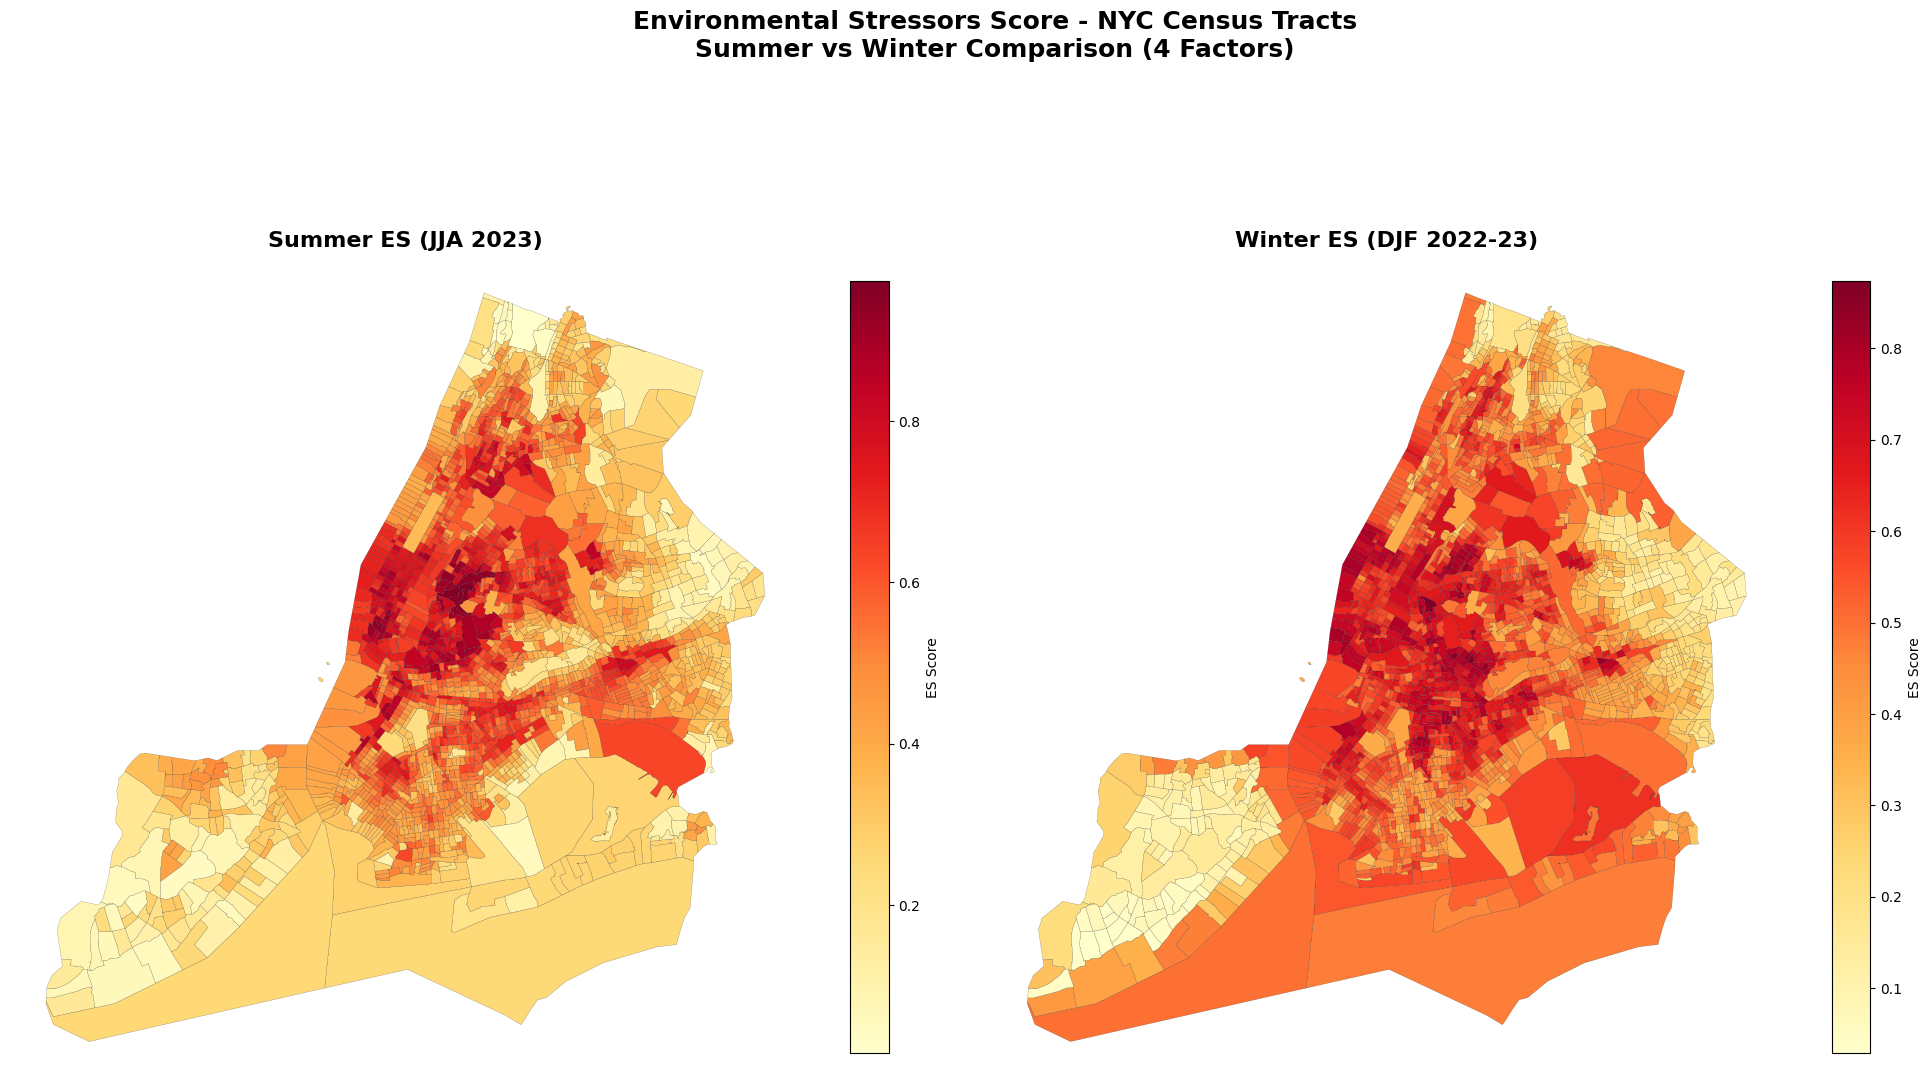

In [ ]:
# Create Summer vs Winter ES Comparison Map
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# Summer ES
gdf_es.plot(
    column='ES_Summer',
    ax=axes[0],
    legend=True,
    cmap='YlOrRd',
    edgecolor='black',
    linewidth=0.1,
    legend_kwds={'label': 'ES Score', 'shrink': 0.7},
    missing_kwds={'color': 'lightgrey'}
)
axes[0].set_title('Summer ES (JJA 2023)', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Winter ES
gdf_es.plot(
    column='ES_Winter',
    ax=axes[1],
    legend=True,
    cmap='YlOrRd',
    edgecolor='black',
    linewidth=0.1,
    legend_kwds={'label': 'ES Score', 'shrink': 0.7},
    missing_kwds={'color': 'lightgrey'}
)
axes[1].set_title('Winter ES (DJF 2022-23)', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Environmental Stressors Score - NYC Census Tracts\nSummer vs Winter Comparison (4 Factors)', 
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../Pitch3/ES_Summer_Winter_Comparison.png', dpi=300, bbox_inches='tight')
print("Comparison map saved!")
plt.show()

Saved: ES_4Factors_Summer_Winter.png


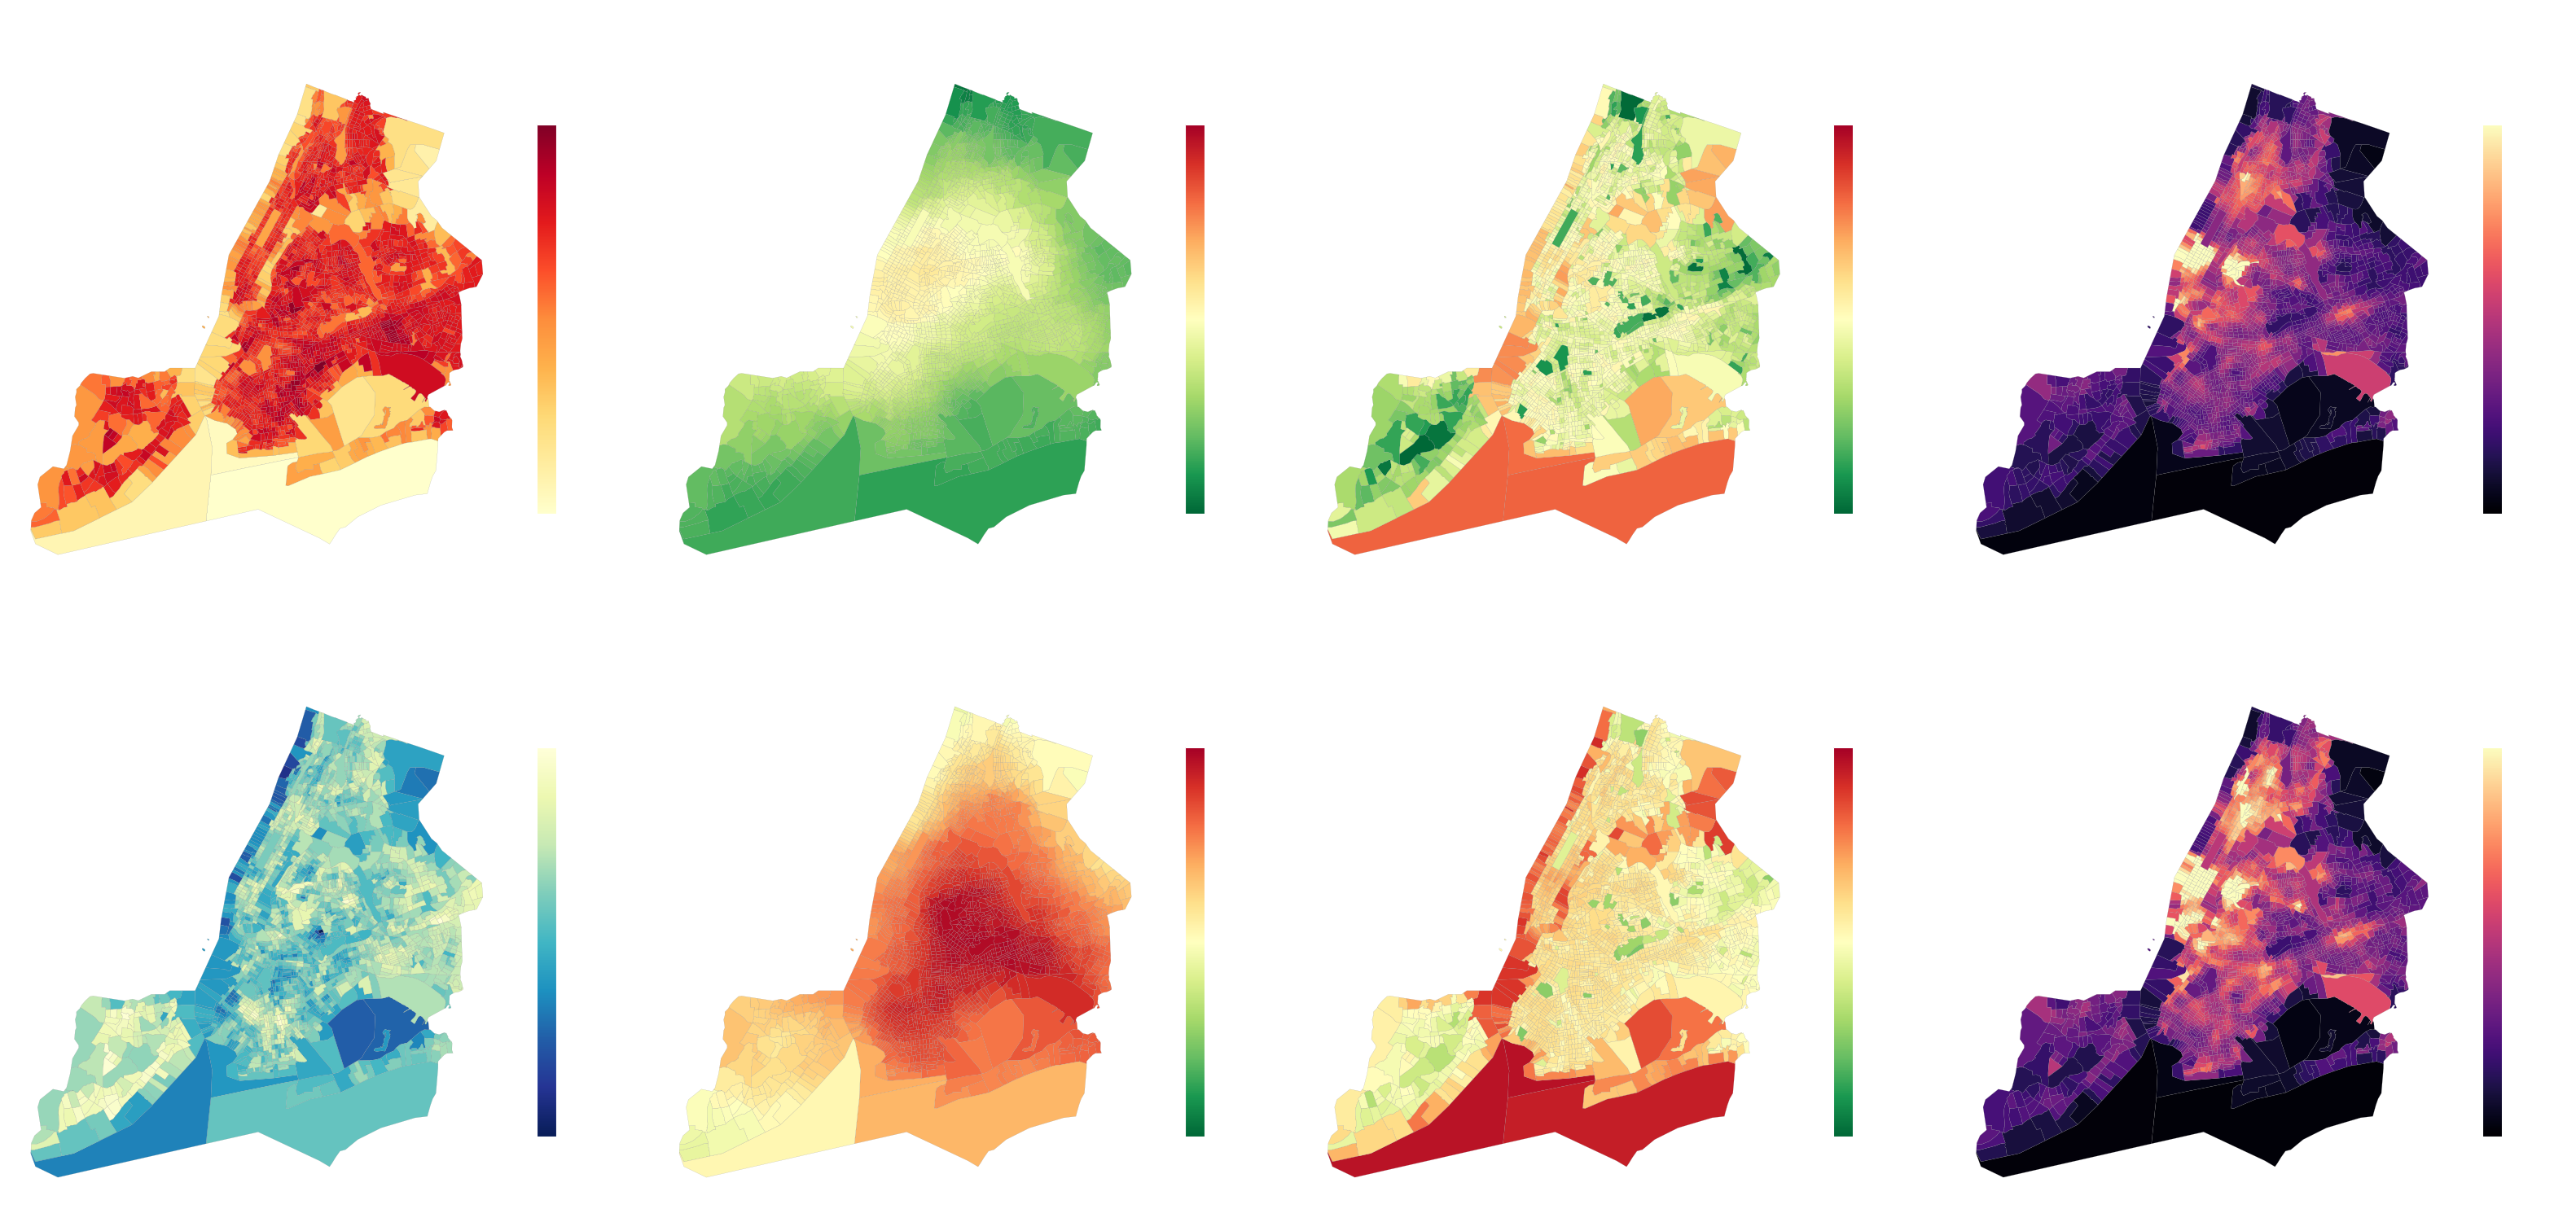

In [36]:
# Create 2x4 grid showing all ES factors for Summer and Winter (horizontal layout)
# Using shared min/max ranges for fair comparison

fig, axes = plt.subplots(2, 4, figsize=(32, 16))
fig.patch.set_alpha(0)  # Transparent figure background

# Color palettes
temp_summer_cmap = 'YlOrRd'  # Yellow-Orange-Red for heat
temp_winter_cmap = 'YlGnBu_r'  # Blue for cold (reversed so cold=dark)
no2_cmap = 'RdYlGn_r'  # Red=bad, Green=good (reversed)
veg_cmap = 'RdYlGn_r'  # Red=no vegetation, Green=vegetation (reversed for lack)
ntl_cmap = 'magma'  # Dark to bright for lights

# Shared ranges for fair comparison
no2_min, no2_max = 60, 180   # Air Quality (NO2) shared range
veg_min, veg_max = 0.4, 1.4  # Vegetation Lack shared range
ntl_min, ntl_max = 0, 135    # Nighttime Lights shared range (95th percentile cap)

# Row 0: Summer (4 factors)
# Temperature Summer
axes[0,0].patch.set_alpha(0)
gdf_es.plot(column='Temp_Summer', ax=axes[0,0], legend=True, cmap=temp_summer_cmap,
            edgecolor='grey', linewidth=0.1, legend_kwds={'label': '°C', 'shrink': 0.6},
            missing_kwds={'color': 'lightgrey'})
axes[0,0].set_title('1. Temperature - SUMMER\n(Higher = Heat Stress)', fontsize=22, fontweight='bold', color='white')
axes[0,0].axis('off')

# Air Quality Summer (shared range)
axes[0,1].patch.set_alpha(0)
gdf_es.plot(column='Air_Quality_Summer', ax=axes[0,1], legend=True, cmap=no2_cmap,
            edgecolor='grey', linewidth=0.1,
            vmin=no2_min, vmax=no2_max,
            legend_kwds={'label': 'μmol/m²', 'shrink': 0.6},
            missing_kwds={'color': 'lightgrey'})
axes[0,1].set_title('2. Air Quality (NO2) - SUMMER\n(Higher = More Pollution)', fontsize=22, fontweight='bold', color='white')
axes[0,1].axis('off')

# Vegetation Lack Summer (shared range)
axes[0,2].patch.set_alpha(0)
gdf_es.plot(column='Vegetation_Lack_Summer', ax=axes[0,2], legend=True, cmap=veg_cmap,
            edgecolor='grey', linewidth=0.1, 
            vmin=veg_min, vmax=veg_max,
            legend_kwds={'label': '1-NDVI', 'shrink': 0.6},
            missing_kwds={'color': 'lightgrey'})
axes[0,2].set_title('3. Vegetation Lack - SUMMER\n(Higher = Less Green Space)', fontsize=22, fontweight='bold', color='white')
axes[0,2].axis('off')

# Light Pollution Summer (shared range)
axes[0,3].patch.set_alpha(0)
gdf_es.plot(column='NTL_Summer', ax=axes[0,3], legend=True, cmap=ntl_cmap,
            edgecolor='grey', linewidth=0.1, 
            vmin=ntl_min, vmax=ntl_max,
            legend_kwds={'label': 'nW/cm²/sr', 'shrink': 0.6},
            missing_kwds={'color': 'lightgrey'})
axes[0,3].set_title('4. Light Pollution - SUMMER\n(Higher = Urban Stress)', fontsize=22, fontweight='bold', color='white')
axes[0,3].axis('off')

# Row 1: Winter (4 factors)
# Temperature Winter
axes[1,0].patch.set_alpha(0)
gdf_es.plot(column='Temp_Winter', ax=axes[1,0], legend=True, cmap=temp_winter_cmap,
            edgecolor='grey', linewidth=0.1, legend_kwds={'label': '°C', 'shrink': 0.6},
            missing_kwds={'color': 'lightgrey'})
axes[1,0].set_title('1. Temperature - WINTER\n(Lower = Cold Stress)', fontsize=22, fontweight='bold', color='white')
axes[1,0].axis('off')

# Air Quality Winter (shared range)
axes[1,1].patch.set_alpha(0)
gdf_es.plot(column='Air_Quality_Winter', ax=axes[1,1], legend=True, cmap=no2_cmap,
            edgecolor='grey', linewidth=0.1,
            vmin=no2_min, vmax=no2_max,
            legend_kwds={'label': 'μmol/m²', 'shrink': 0.6},
            missing_kwds={'color': 'lightgrey'})
axes[1,1].set_title('2. Air Quality (NO2) - WINTER\n(Higher = More Pollution)', fontsize=22, fontweight='bold', color='white')
axes[1,1].axis('off')

# Vegetation Lack Winter (shared range)
axes[1,2].patch.set_alpha(0)
gdf_es.plot(column='Vegetation_Lack_Winter', ax=axes[1,2], legend=True, cmap=veg_cmap,
            edgecolor='grey', linewidth=0.1,
            vmin=veg_min, vmax=veg_max,
            legend_kwds={'label': '1-NDVI', 'shrink': 0.6},
            missing_kwds={'color': 'lightgrey'})
axes[1,2].set_title('3. Vegetation Lack - WINTER\n(Higher = Less Green Space)', fontsize=22, fontweight='bold', color='white')
axes[1,2].axis('off')

# Light Pollution Winter (shared range)
axes[1,3].patch.set_alpha(0)
gdf_es.plot(column='NTL_Winter', ax=axes[1,3], legend=True, cmap=ntl_cmap,
            edgecolor='grey', linewidth=0.1,
            vmin=ntl_min, vmax=ntl_max,
            legend_kwds={'label': 'nW/cm²/sr', 'shrink': 0.6},
            missing_kwds={'color': 'lightgrey'})
axes[1,3].set_title('4. Light Pollution - WINTER\n(Higher = Urban Stress)', fontsize=22, fontweight='bold', color='white')
axes[1,3].axis('off')

# Style all colorbars
for i, ax in enumerate(fig.axes):
    if i >= 8:  # Colorbar axes
        ax.tick_params(colors='white', labelsize=16)
        ax.yaxis.label.set_color('white')
        ax.yaxis.label.set_fontsize(18)
        for spine in ax.spines.values():
            spine.set_color('white')

plt.tight_layout()
plt.savefig('../Pitch3/ES_4Factors_Summer_Winter.png', dpi=300, bbox_inches='tight', transparent=True)
print("Saved: ES_4Factors_Summer_Winter.png")
plt.show()

## 11. Borough-Level Summary

In [ ]:
borough_labels = {
    '005': 'Bronx',
    '047': 'Brooklyn',
    '061': 'Manhattan',
    '081': 'Queens',
    '085': 'Staten Island'
}

# Summary by borough - Summer
print("\nSummer ES Statistics by Borough:")
summer_summary = gdf_es.groupby('COUNTYFP')['ES_Summer'].agg(['mean', 'median', 'std'])
summer_summary.index = summer_summary.index.map(borough_labels)
print(summer_summary.round(3))

# Summary by borough - Winter
print("\nWinter ES Statistics by Borough:")
winter_summary = gdf_es.groupby('COUNTYFP')['ES_Winter'].agg(['mean', 'median', 'std'])
winter_summary.index = winter_summary.index.map(borough_labels)
print(winter_summary.round(3))


Summer ES Statistics by Borough:
                mean  median    std
COUNTYFP                           
Bronx          0.444   0.445  0.184
Brooklyn       0.531   0.521  0.156
Manhattan      0.630   0.651  0.154
Queens         0.481   0.476  0.199
Staten Island  0.254   0.267  0.119

Winter ES Statistics by Borough:
                mean  median    std
COUNTYFP                           
Bronx          0.434   0.451  0.148
Brooklyn       0.582   0.586  0.120
Manhattan      0.596   0.598  0.117
Queens         0.457   0.471  0.174
Staten Island  0.177   0.135  0.132


## 12. Save Processed Data

In [ ]:
# Save ES data as GeoJSON
output_cols = ['GEOID', 'NAMELSAD', 'COUNTYFP', 'LCS', 
               'ES_Summer', 'ES_Winter'] + es_factors + ['geometry']

# ES file
gdf_es[output_cols].to_file('../Pitch3/ES_NYC_2023.geojson', driver='GeoJSON')
print("Saved: ES_NYC_2023.geojson")

# CSV for easy analysis
gdf_es.drop(columns=['geometry'])[output_cols[:-1]].to_csv('../Pitch3/ES_NYC_2023.csv', index=False)
print("Saved: ES_NYC_2023.csv")

Saved: ES_NYC_2023.geojson
Saved: ES_NYC_2023.csv


## 13. Top 10 Highest ES Tracts

In [ ]:
# Top 10 highest Summer ES tracts
print("\nTop 10 Census Tracts - Highest SUMMER Environmental Stress:")
top_summer = gdf_es.nlargest(10, 'ES_Summer')[['NAMELSAD', 'COUNTYFP', 'ES_Summer']]
top_summer['Borough'] = top_summer['COUNTYFP'].map(borough_labels)
print(top_summer[['NAMELSAD', 'Borough', 'ES_Summer']].to_string())

print("\n" + "="*60)

# Top 10 highest Winter ES tracts
print("\nTop 10 Census Tracts - Highest WINTER Environmental Stress:")
top_winter = gdf_es.nlargest(10, 'ES_Winter')[['NAMELSAD', 'COUNTYFP', 'ES_Winter']]
top_winter['Borough'] = top_winter['COUNTYFP'].map(borough_labels)
print(top_winter[['NAMELSAD', 'Borough', 'ES_Winter']].to_string())


Top 10 Census Tracts - Highest SUMMER Environmental Stress:
                 NAMELSAD    Borough  ES_Summer
327   Census Tract 179.02     Queens   0.973786
143     Census Tract 1.04     Queens   0.965084
391   Census Tract 199.01     Queens   0.963580
1954      Census Tract 45  Manhattan   0.951547
388   Census Tract 199.02     Queens   0.945531
1955      Census Tract 47  Manhattan   0.942200
526   Census Tract 171.01     Queens   0.939729
823   Census Tract 589.02   Brooklyn   0.939622
525   Census Tract 171.02     Queens   0.939085
647    Census Tract 55.02  Manhattan   0.934035


Top 10 Census Tracts - Highest WINTER Environmental Stress:
                 NAMELSAD   Borough  ES_Winter
1301     Census Tract 441  Brooklyn   0.873657
838   Census Tract 579.02  Brooklyn   0.868285
1270     Census Tract 427  Brooklyn   0.855608
370      Census Tract 555    Queens   0.836162
925      Census Tract 159    Queens   0.827245
1029      Census Tract 51    Queens   0.825312
235      Census Trac

---
## Next Steps

1. Run `03_LRS_Combined_Score.ipynb` to combine LCS + ES into final LRS
2. LRS_Summer = 0.50×LCS + 0.50×ES_Summer
3. LRS_Winter = 0.50×LCS + 0.50×ES_Winter
4. Quadrant analysis for priority zone identification

## ES Formula Summary (4 Factors)
```
ES = 0.25×Temperature + 0.25×Air_Quality + 0.25×Vegetation_Lack + 0.25×Light_Pollution
```

| Factor | Source | Resolution | Stress Direction |
|--------|--------|------------|------------------|
| **Temperature** | Landsat 9 LST | 100m | Summer: higher=stress, Winter: lower=stress |
| **Air Quality** | Sentinel-5P NO2 | ~7km | Higher NO2 = more stress |
| **Vegetation Lack** | 1 - NDVI (Sentinel-2) | 10m | Higher = more stress |
| **Light Pollution** | VIIRS DNB | 500m | Higher = more stress (sleep disruption, urban intensity) |